In [10]:
import argparse, os
import sigpy as sp
import scipy.ndimage as ndimage_c
import numpy as np
import scipy.io as sio
import sys
sys.path.append("./sigpy_e/")
import sigpy_e.cfl as cfl 

import sigpy_e.ext as ext
import sigpy_e.reg as reg
from sigpy_e.linop_e import NFTs,Diags,DLD,Vstacks
import sigpy.mri as mr
import sigpy.plot as pl

In [11]:
## data loading
fname = '/data/Jiahao/spiral/fb-data/110422-6/ex17087-P37376'
data_all = cfl.read_cfl(os.path.join(fname,'ksp'))
traj_all = np.real(cfl.read_cfl(os.path.join(fname,'traj')))
mps = cfl.read_cfl(os.path.join(fname, 'sens'))
kdens = np.squeeze(sio.loadmat(os.path.join(fname, 'kdens.mat'))['kdens'])
nresp, ncard, ne, nCoil, npe, nfe = np.squeeze(data_all).shape
tshape = (28, 256, 256)

In [12]:
## test on a fixed resp phase and all card phases
nphase = ncard
kdens_one = np.ones(nfe)
traj = np.squeeze(traj_all)[0,:,np.newaxis,np.newaxis,...]
data = np.squeeze(data_all)[0,:,np.newaxis,1,...,np.newaxis]
dcf = np.tile(kdens_one, (nphase, npe, 1))[:,np.newaxis,np.newaxis,...,np.newaxis]
S = sp.linop.Multiply(tshape, mps)
# recon params
lambda_TV = 0.05
outer_iter = 20
device = 0
# rescale
# fov_scale = [1, 1, 5]
# traj[...,0] = traj[...,0]*fov_scale[0]
# traj[...,1] = traj[...,1]*fov_scale[1]
# traj[...,2] = traj[...,2]*fov_scale[2]
traj[...,[0,2]] = traj[...,[2,0]]

In [13]:
# xd-grasp recon test
PFTSs = []
for i in range(nphase):
    FTs = NFTs((nCoil,)+tshape,traj[i,0,0,...],device=sp.Device(device))
    W = sp.linop.Multiply((nCoil,npe,nfe,),dcf[i,0,0,:,:,0]) 
    FTSs = W*FTs*S
    PFTSs.append(FTSs)
PFTSs = Diags(PFTSs,oshape=(nphase,nCoil,npe,nfe,),ishape=(nphase,)+tshape)

## preconditioner
wdata = data[:,0,:,:,:,0]*dcf[:,0,:,:,:,0]
tmp = PFTSs.H*PFTSs*np.complex64(np.ones((nphase,)+tshape))
L=np.mean(np.abs(tmp))

## reconstruction
q2 = np.zeros((nphase,)+tshape,dtype=np.complex64)
Y = np.zeros_like(wdata)
q20 = np.zeros_like(q2)

sigma = 0.4
tau = 0.4
for i in range(outer_iter):
    Y = (Y + sigma*(1/L*PFTSs*q2-wdata))/(1+sigma)
    
    q20 = q2
    q2 = np.complex64(ext.TVt_prox(q2-tau*PFTSs.H*Y,lambda_TV))
    print('outer iter:{}, res:{}'.format(i,np.linalg.norm(q2-q20)/np.linalg.norm(q2)))

    cfl.write_cfl(os.path.join(fname,'mrL'), q2)

outer iter:0, res:1.0
outer iter:1, res:0.6240596771240234
outer iter:2, res:0.43733271956443787
outer iter:3, res:0.326974481344223
outer iter:4, res:0.25528132915496826
outer iter:5, res:0.20589905977249146
outer iter:6, res:0.1704404205083847
outer iter:7, res:0.14410758018493652
outer iter:8, res:0.12396380305290222
outer iter:9, res:0.10815484821796417
outer iter:10, res:0.09547992050647736
outer iter:11, res:0.08514103293418884
outer iter:12, res:0.07658854126930237
outer iter:13, res:0.0694267600774765
outer iter:14, res:0.06336057931184769
outer iter:15, res:0.058166373521089554
outer iter:16, res:0.05367373302578926
outer iter:17, res:0.0497528500854969
outer iter:18, res:0.046304456889629364
outer iter:19, res:0.043250761926174164


In [14]:
# plot iMoCo image
irecon = cfl.read_cfl(os.path.join(fname,'mrL'))
irecon.shape

(12, 28, 256, 256)

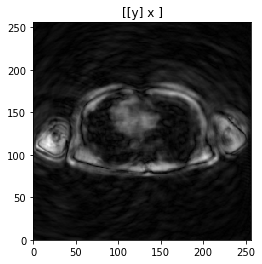

In [15]:
pl.ImagePlot(irecon[0,23,...], x = -1, y = -2)